### HW recap and setup

We will train Random Forest classifier and Gradient Boosting classifier for MNIST.

Use the seed 0 everywhere.

1. Import MNIST data as we did in Lecture 7. We are only going to use digit 0 and digit 1. So extract only those examples and discard the rest.

Next, randomly split the data into 80% training data and 20% testing data. Then split the training data again into 75% training data and 25% validation data. Keep this split fixed throughout the experiments.

2. Use the validation set to choose the optimal hyperparameters "n_estimators" and "max_depth" for Random Forest, and report the best hyperparameters and the best validation error. The suggested hyperparameter values are

    - ns_estimators = [10,20,50,100,200]
    - max_depths = [1,2,5,10,20]

3. Train Random Forest again with all data (i.e., training + validation data). Report the training and the test error.

4. Plot the feature importance as an image, as we did in Lecture 7.

5. Repeat 2 with Gradient Boosting.

6. Repeat 3 with Gradient Boosting

7. Repeat 4 with Gradient Boosting.

In [17]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Reading the data

In [18]:
from sklearn.datasets import load_digits

data = load_digits()
X = data["data"]
Y = data["target"] 


### 1. Plot the first 100 images (with 10 images per row) as you did with MNIST

Again, I'm stealing the code from class to plot and changing the size to make it work with the digits data base

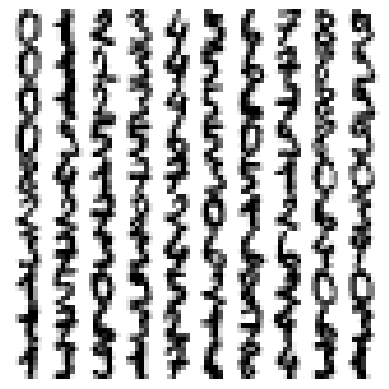

In [19]:
def plot_digits(instances, images_per_row=10, **options):
    size = 8
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1 

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plot_digits(X[0:100])

### 2. Randomly split the data into 80% training data and 20% testing data. Keep this split fixed.

I will use pretty much the same procedure I used on the previous HW, create a permutation and then take the first 80%

In [20]:
m = len(Y)
np.random.seed(0)

# create a random index permutation
ind =np.array(range(0,m))
ind = np.random.permutation(ind)

In [21]:
# first 80% for train and last 20% for test 
split = int(m*0.8)
train_ind = ind[0:split]
test_ind = ind[split:m]

print(Y)
print(Y[train_ind])

[0 1 2 ... 8 9 8]
[2 8 2 ... 5 2 8]


### 3. For each value of Cs = [1E-5,1E-4,1E-3,1E-2,1E-1,1E0]

#### (a) instantiate LogisticRegression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning

import warnings # to catch warnings


C=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]
cv=[]

with warnings.catch_warnings():  # to remove convergence warning output
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    # for each c value fit to the train data and save the 4-cross validation scores
    for c in C:
        reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", penalty="l2", C=c, random_state=0, max_iter=1000)
        cv.append( cross_val_score(reg, X[train_ind], Y[train_ind], cv =4) )

#### (b) measure 4-fold cross_validation error

In [23]:
# To compare we find the mean of each 4-cross validation's scores
cvmean = []
for i in range(6):
    print(cv[i])
    cvmean.append(np.average(cv[i]))
print("mean cv values")
print(cvmean)

# The better model corresponds to the higher score
maxcv = np.max(cvmean)
max = np.argmax(cvmean)
print("max cv ", maxcv, " at ", C[max])


[0.86388889 0.86629526 0.87743733 0.86908078]
[0.91944444 0.90250696 0.91922006 0.9275766 ]
[0.94444444 0.94428969 0.96100279 0.95264624]
[0.95833333 0.96100279 0.9637883  0.9637883 ]
[0.96111111 0.95821727 0.95821727 0.9637883 ]
[0.96388889 0.95543175 0.94428969 0.95821727]
mean cv values
[0.8691755648406065, 0.9171870164035902, 0.9505957907768492, 0.9617281801299907, 0.9603334880841844, 0.9554569018879604]
max cv  0.9617281801299907  at  0.01


### 4. Now use the hyperparameter to retrain the model from scratch using all training data. Report the train and test error of this final model.

We will use $C=0.01$ since this value yield better mean cross validation score, to find the train and test scores (notice we will be using the `score` method as the error, which corresponds to the cross validation error calculation)

In [24]:
# fit to the train data
reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", penalty="l2", C=C[max], random_state=0, max_iter=1000)
reg.fit(X=X[train_ind],y=Y[train_ind])

# train error
train_error = reg.score(X[train_ind],Y[train_ind])
print(train_error)

# test error
test_error = reg.score(X[test_ind],Y[test_ind])
print(test_error)


0.9902574808629089
0.9777777777777777


That is, the training score is $99.02\%$ (or $0.98\%$ error) and the test score is $97.77\%$ (or $2.23\%$ error).

### 5. Repeat 3 with LogisticRegression(..., penalty="l1", C=C, random_state=0, max_iter=1000, solver='saga')
Now lets rinse and repeat

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning

import warnings # to catch warnings


C=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]
cv=[]

with warnings.catch_warnings():  # to remove convergence warning output
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    # for each c value fit to the train data and save the 4-cross validation scores
    for c in C:
        # new regressor
        reg = LogisticRegression(multi_class="multinomial",solver="saga", penalty="l1", C=c, random_state=0, max_iter=1000)
        cv.append( cross_val_score(reg, X[train_ind], Y[train_ind], cv =4) )

In [26]:
# Find the mean of each 4-cross validation's scores
cvmean = []
for i in range(6):
    print(cv[i])
    cvmean.append(np.average(cv[i]))
print("mean cv values")
print(cvmean)

# The better model corresponds to the higher score
maxcv = np.max(cvmean)
max = np.argmax(cvmean)
print("max cv ", maxcv, " at ", C[max])


[0.1        0.10306407 0.10306407 0.10306407]
[0.1        0.10306407 0.10306407 0.10584958]
[0.22222222 0.23119777 0.15877437 0.16155989]
[0.91388889 0.91086351 0.93314763 0.92200557]
[0.95       0.95821727 0.95543175 0.96657382]
[0.96111111 0.9637883  0.95543175 0.96100279]
mean cv values
[0.10229805013927576, 0.10299442896935933, 0.1934385639121015, 0.9199764004952027, 0.9575557103064066, 0.9603334880841845]
max cv  0.9603334880841845  at  1.0


### 6. Repeat 4 with LogisticRegression(..., penalty="l1", C=C, random_state=0, max_iter=1000, solver='saga')
The first scores for this one really suck, the best result happens when $C=1$.

In [28]:
# fit to the train data
reg = LogisticRegression(multi_class="multinomial",solver="saga", penalty="l1", C=C[max], random_state=0, max_iter=1000)
reg.fit(X=X[train_ind],y=Y[train_ind])

# train error
train_error = reg.score(X[train_ind],Y[train_ind])
print(train_error)

# test error
test_error = reg.score(X[test_ind],Y[test_ind])
print(test_error)


1.0
0.9694444444444444


c:\Users\Paquito\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Which yields a $100\%$ train score (or $0\%$ error) and a $96.94\%$ test score (or $3.06\%$ error) 